In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn import metrics
from utilities import plot_confusion_matrix,plot_roc_auc,plot_classification_report,grid_search_simple,graph_result
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("../../data/indeed.input.csv")
y = df['salaire_moyen'][pd.notnull(df['salaire_moyen'])]
X = df.drop(columns = ['salaire_min','salaire_max','salaire_moyen','3 mois renouvelable_desc','3mois renouvelable_desc'])
X = X[pd.notnull(df['salaire_moyen'])]

In [3]:
kmeans = KMeans(n_clusters=4,init = 'k-means++', max_iter=1000).fit(y.values.reshape(-1, 1))
y_class = kmeans.labels_

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.25, random_state=0)

## Reduction des Features

### Par Random Forest

In [13]:
# Create a random forest classifier
clf_scl_ftrs = RandomForestClassifier(bootstrap=False, criterion='gini',
                max_features='log2', min_samples_split=5,
                n_estimators=50, verbose=0, warm_start=False)


# Train the classifier
clf_scl_ftrs.fit(X_train, y_train)

scl_ftrs_accuracy = []
X_important_trains = []
X_important_tests = []
features_fits = []
for thresh in [0.001,0.003,0.005,0.005, 0.01, 0.02, 0.05, 0.055]:
#for thresh in np.arange(0.001, np.max(clf_scl_ftrs.feature_importances_), 0.01):
    try:
        sfm = SelectFromModel(clf_scl_ftrs, threshold=thresh)
        sfm.fit(X_train, y_train)
        X_important_train = sfm.transform(X_train)
        X_important_test = sfm.transform(X_test)
        features_fit = [X_train.columns[feature_list_index] for feature_list_index in sfm.get_support(indices=True)] 
        clf_scl_ftrs.fit(X_important_train, y_train)
        y_pred_1 = clf_scl_ftrs.predict(X_important_test)
        scl_ftrs_accuracy.append(metrics.accuracy_score(y_test, y_pred_1))
        X_important_trains.append(X_important_train)
        X_important_tests.append(X_important_test)
        features_fits.append(features_fit)
    except:
        print("Pas de colonne pour : ",thresh)
    

print("{0} best features".format(len(features_fits[np.argmax(scl_ftrs_accuracy)])))
print("accuracy : ", scl_ftrs_accuracy[np.argmax(scl_ftrs_accuracy)])
print("\n")
print(features_fits[np.argmax(scl_ftrs_accuracy)])
selected_features = features_fits[np.argmax(scl_ftrs_accuracy)]

63 best features
accuracy :  0.8261758691206544


['Lyon', 'Nantes', 'Paris', 'Toulouse', 'bac + 2', 'bac + 3', 'bac + 4', 'bac + 5', 'ingénieur', 'CDI', 'Freelance', 'Stage', 'Temps plein', 'cdi_titre', 'freelance_titre', 'stage_titre', 'cdd_desc', 'cdi_desc', 'freelance_desc', 'stage_desc', 'développeur web', 'front-end', 'asp.net', 'back end', 'c', 'c#', 'c\\+\\+', 'clean', 'css', 'e', 'excel', 'html', 'java', 'javascript', 'kotlin', 'linux', 'mongodb', 'mysql', 'nosql', 'php', 'python', 'scala', 'soap', 'sql', 'swift', 'xml', 'symfony', 'jquery', 'angular', 'react', 'git', 'github', 'visual studio', 'django', 'api rest', 'docker', 'jira', 'scrum', 'kanban', 'azure', 'aws', 'jenkins', 'centre']


**Regression Logistique**

In [15]:
%%time
logreg_estimator = grid_search_simple("logreg","logreg_fs_randf", X_train[selected_features], y_train)

Wall time: 0 ns


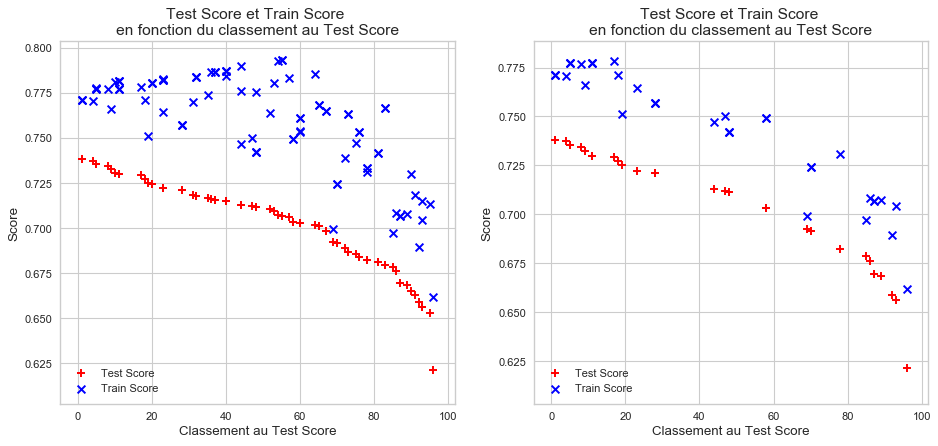

In [5]:
graph_result("logreg_fs_randf.csv")

**SVM**

In [6]:
%%time
svm_estimator = grid_search_simple("SVM","SVM_fs_randf", X_train, y_train)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Wall time: 11min 51s


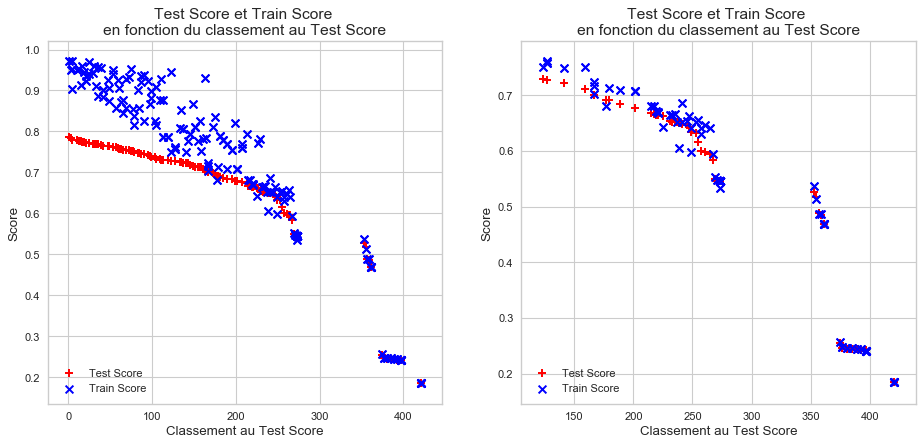

In [7]:
graph_result("SVM_fs_randf.csv")